In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from ultralytics import YOLO
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import atan2, degrees

warnings.filterwarnings('ignore')


In [2]:

# 1. Nose
# 2. Left Eye
# 3. Right Eye
# 4. Left Ear
# 5. Right Ear
# 6. Left Shoulder
# 7. Right Shoulder
# 8. Left Elbow
# 9. Right Elbow
# 10. Left Wrist
# 11. Right Wrist
# 12. Left Hip
# 13. Right Hip
# 14. Left Knee
# 15. Right Knee
# 16. Left Ankle
# 17. Right Ankle

skeleton = [
    (16, 14), (14, 12), (17, 15), (15, 13), (12, 13),
    (6, 12), (7, 13), (6, 7), (6, 8), (7, 9),
    (8, 10), (9, 11), (2, 3), (1, 2), (1, 3),
    (2, 4), (3, 5), (4, 6), (5, 7)
]

# Загрузка модели YOLOv8 для позы
model = YOLO("yolo11x-pose.pt")

def extract_keypoints_from_frame(frame, model, confidence_threshold=0.5):
    """
    Извлекает ключевые точки позы из одного кадра.
    Возвращает массив формы (17, 2) или массив заполненный нулями, если поза не обнаружена.
    """
    results = model.predict(source=frame, save=False, verbose=False)
    
    if not results:
        return np.zeros((17, 2), dtype=np.float32)
    
    for result in results:
        if result.keypoints is not None:
            keypoints_np = result.keypoints.cpu().numpy()
            if hasattr(keypoints_np, 'xyn'):
                pose = keypoints_np.xyn
                # Проверка формы ключевых точек
                if pose.ndim == 3 and pose.shape[1:] == (17, 2):
                    pose = pose[0]  # Извлекаем первую позу, если их несколько
                elif pose.ndim == 2 and pose.shape == (17, 2):
                    pass  # Всё в порядке
                else:
                    print(f"Неправильная форма ключевых точек: {pose.shape}")
                    return np.zeros((17, 2), dtype=np.float32)
                
                # Возвращаем ключевые точки
                return pose
    return np.zeros((17, 2), dtype=np.float32)

def compute_distance(kp1, kp2):
    """Вычисляет Евклидово расстояние между двумя ключевыми точками."""
    return np.linalg.norm(kp1 - kp2)

def compute_angle(kp1, kp2, kp3):
    """Вычисляет угол в kp2, образованный kp1-kp2-kp3."""
    v1 = kp1 - kp2
    v2 = kp3 - kp2
    angle_rad = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    angle_deg = degrees(angle_rad)
    return angle_deg if angle_deg >= 0 else angle_deg + 360

data_dir = r"D:\sports activities"

exercise_classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

data = []

FRAME_RATE = 1  #

for exercise in tqdm(exercise_classes, desc="Обработка классов"):
    exercise_path = os.path.join(data_dir, exercise)
    
    video_files = [f for f in os.listdir(exercise_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    for video_name in tqdm(video_files, desc=f"Обработка {exercise}", leave=False):
        video_path = os.path.join(exercise_path, video_name)
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Не удалось открыть видео: {video_path}")
            continue
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0:
            fps = 30  #
        
        frame_interval = int(fps / FRAME_RATE)
        frame_count = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count % frame_interval == 0:
                keypoints = extract_keypoints_from_frame(frame, model)
                if keypoints is not None:
                    frame_data = {
                        'video': video_name,
                        'class': exercise,
                        'frame_number': frame_count  
                    }
                    
                    for idx, (x, y) in enumerate(keypoints, start=1):
                        frame_data[f'kp{idx}_x'] = x
                        frame_data[f'kp{idx}_y'] = y
                    
                    # Вычисление расстояний на основе скелета
                    for connection in skeleton:
                        kp1_idx, kp2_idx = connection
                        kp1 = keypoints[kp1_idx - 1]
                        kp2 = keypoints[kp2_idx - 1]
                        distance = compute_distance(kp1, kp2)
                        frame_data[f'distance_{kp1_idx}_{kp2_idx}'] = distance
                    
                    angle_triplets = [
                        (12, 14, 16),  
                        (13, 15, 17),  
                        (2, 4, 6),      
                        (3, 5, 7)      
                    ]
                    
                    for triplet in angle_triplets:
                        kp1_idx, kp2_idx, kp3_idx = triplet
                        if kp3_idx > 17:
                            continue
                        kp1 = keypoints[kp1_idx - 1]
                        kp2 = keypoints[kp2_idx - 1]
                        kp3 = keypoints[kp3_idx - 1]
                        angle = compute_angle(kp1, kp2, kp3)
                        frame_data[f'angle_{kp1_idx}_{kp2_idx}_{kp3_idx}'] = angle
                    
                    data.append(frame_data)
            
            frame_count += 1
        
        cap.release()

df = pd.DataFrame(data)
 


Обработка plank:  14%|█████████▌                                                         | 1/7 [00:06<00:37,  6.26s/it]

Неправильная форма ключевых точек: (1, 0, 2)



Обработка push-up:  22%|█████████████▋                                                 | 15/69 [00:17<00:51,  1.06it/s]

Неправильная форма ключевых точек: (1, 0, 2)



Обработка push-up:  99%|██████████████████████████████████████████████████████████████ | 68/69 [01:08<00:01,  1.30s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



Обработка классов: 100%|█████████████████████████████████████████████████████████████████| 6/6 [04:55<00:00, 49.31s/it]


In [3]:
df

,video,class,frame_number,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,...,distance_1_2,distance_1_3,distance_2_4,distance_3_5,distance_4_6,distance_5_7,angle_12_14_16,angle_13_15_17,angle_2_4_6,angle_3_5_7
0,leg raises_1.MOV,leg raises,0,0.472789,0.123584,0.482250,0.104585,0.462042,0.104918,0.493276,...,0.021224,0.021539,0.011082,0.019354,0.107780,0.111429,183.457378,181.640753,253.725600,105.888197
1,leg raises_1.MOV,leg raises,29,0.475761,0.089138,0.485137,0.070649,0.464826,0.070292,0.495291,...,0.020730,0.021789,0.013600,0.020918,0.108496,0.113883,178.584175,183.791238,216.448626,126.683152
2,leg raises_1.MOV,leg raises,58,0.469486,0.113056,0.478684,0.095163,0.458011,0.095218,0.488484,...,0.020119,0.021210,0.010380,0.019782,0.112872,0.107420,222.340744,234.990227,238.584573,117.656702
3,leg raises_1.MOV,leg raises,87,0.474027,0.155196,0.483513,0.135816,0.464625,0.134359,0.494926,...,0.021577,0.022860,0.011564,0.017927,0.099332,0.104560,178.255233,183.642067,267.034766,90.550420
4,leg raises_1.MOV,leg raises,116,0.467440,0.126439,0.476362,0.108225,0.456454,0.108685,0.487880,...,0.020281,0.020877,0.012180,0.018221,0.112652,0.106764,100.376532,109.953523,239.791823,118.454714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,squat_8.mp4,squat,92,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425219,...,0.000000,0.000000,0.446313,0.491960,0.070300,0.053325,179.556575,180.145884,281.793606,242.520510
2031,squat_9.mp4,squat,0,0.549028,0.194053,0.563095,0.178581,0.000000,0.000000,0.594442,...,0.020911,0.582313,0.039443,0.000000,0.100303,0.637568,315.926681,328.050609,222.402803,28.862378
2032,squat_9.mp4,squat,23,0.534391,0.365546,0.543856,0.358120,0.000000,0.000000,0.565934,...,0.012030,0.647455,0.059334,0.000000,0.153676,0.763411,267.791039,265.904029,209.569929,40.088644
2033,squat_9.mp4,squat,46,0.538671,0.317998,0.546001,0.306695,0.000000,0.000000,0.562448,...,0.013471,0.625531,0.053663,0.000000,0.161262,0.766270,264.870484,226.774100,210.076975,37.405299


In [8]:
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

all_classes = label_encoder.classes_

train_videos, test_videos = train_test_split(
    df['video'].unique(), test_size=0.2, random_state=42
)

train_df = df[df['video'].isin(train_videos)]
test_df = df[df['video'].isin(test_videos)]



X_train = train_df.drop(['video', 'class', 'class_encoded', 'frame_number'], axis=1)
y_train = train_df['class_encoded']

X_test = test_df.drop(['video', 'class', 'class_encoded', 'frame_number'], axis=1)
y_test = test_df['class_encoded']

 


Обучение модели: Logistic Regression
Обучение модели: Decision Tree
Обучение модели: Random Forest
Обучение модели: Support Vector Machine
Обучение модели: K-Nearest Neighbors
Обучение модели: Gradient Boosting
Обучение модели: XGBoost
Обучение модели: Neural Network

Результаты моделей:
                    Model  Accuracy  Precision    Recall  F1-Score
0     Logistic Regression  0.687179   0.645641  0.754004  0.661449
1           Decision Tree  0.720513   0.668064  0.784590  0.688005
2           Random Forest  0.820513   0.810186  0.865488  0.815116
3  Support Vector Machine  0.292308   0.229339  0.375019  0.184410
4     K-Nearest Neighbors  0.471795   0.443823  0.562688  0.434845
5       Gradient Boosting  0.797436   0.777380  0.842904  0.793976
6                 XGBoost  0.833333   0.814297  0.866858  0.827531
7          Neural Network  0.538462   0.506315  0.609405  0.483383


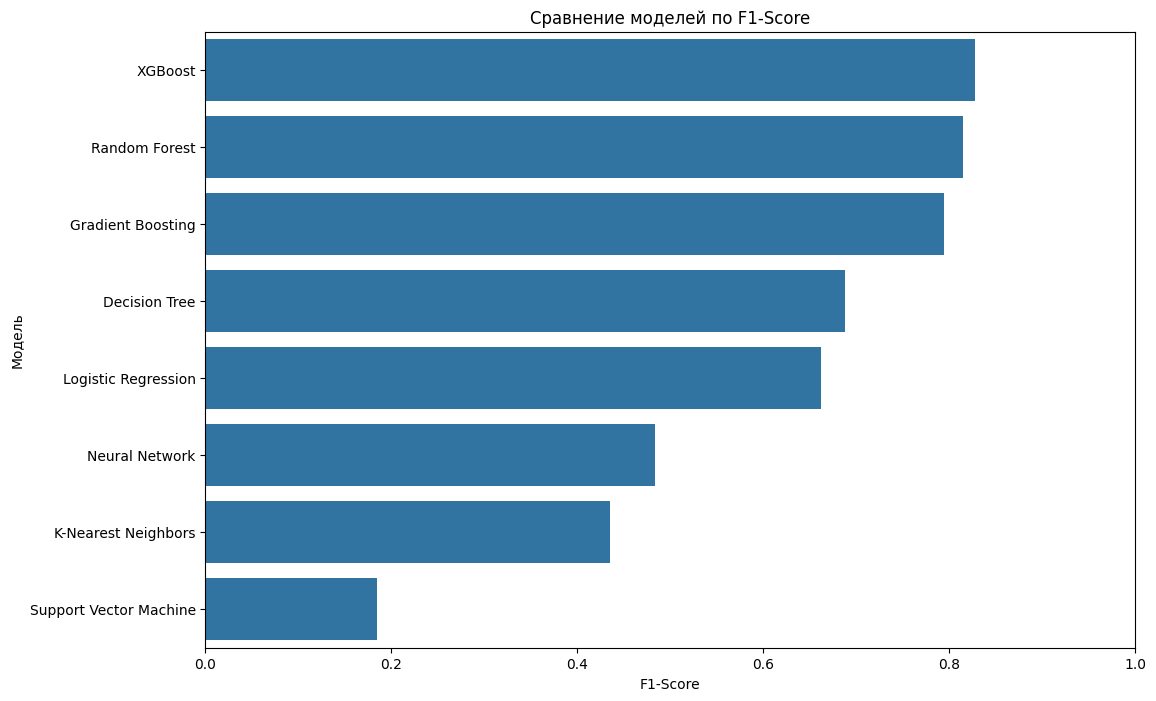

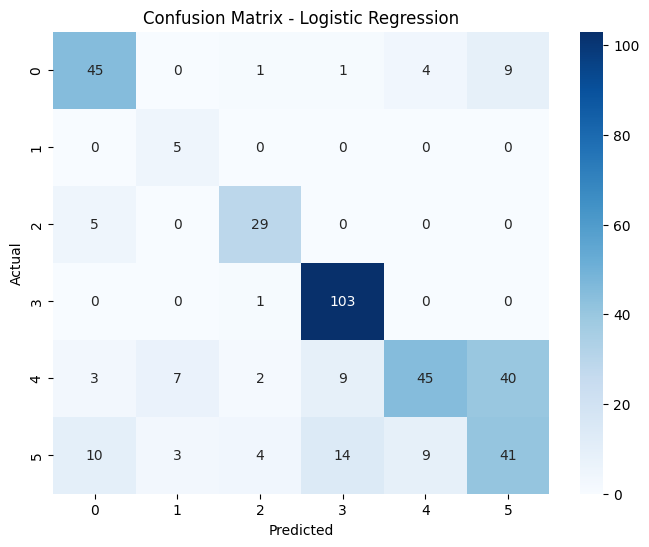

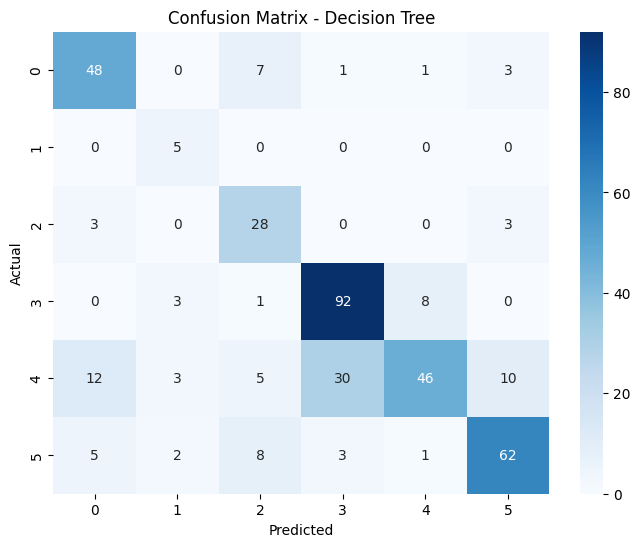

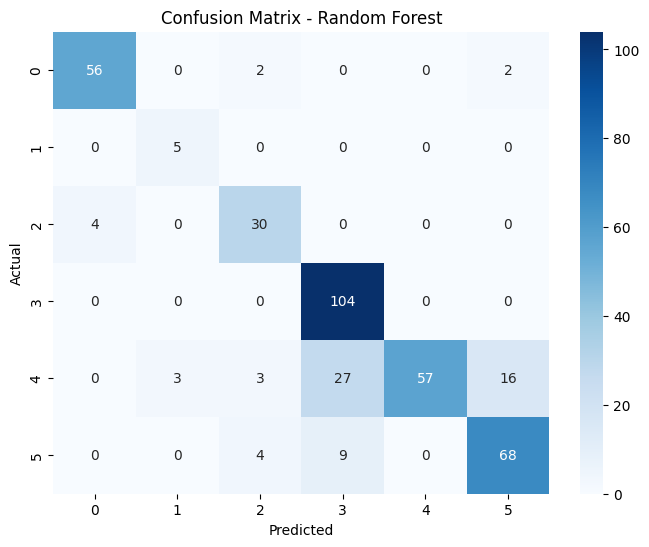

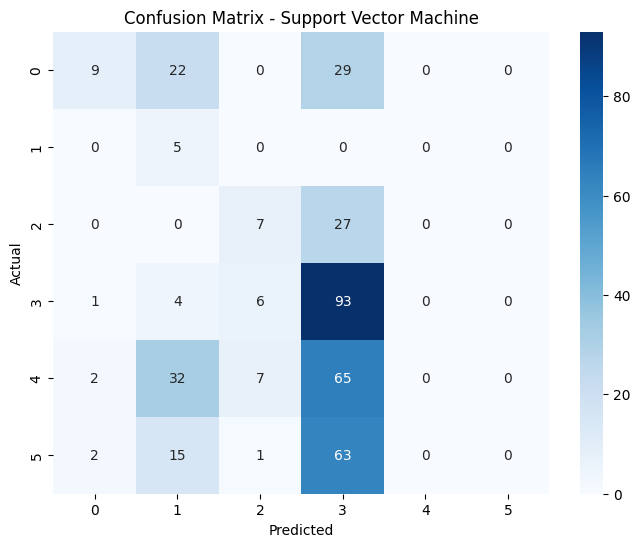

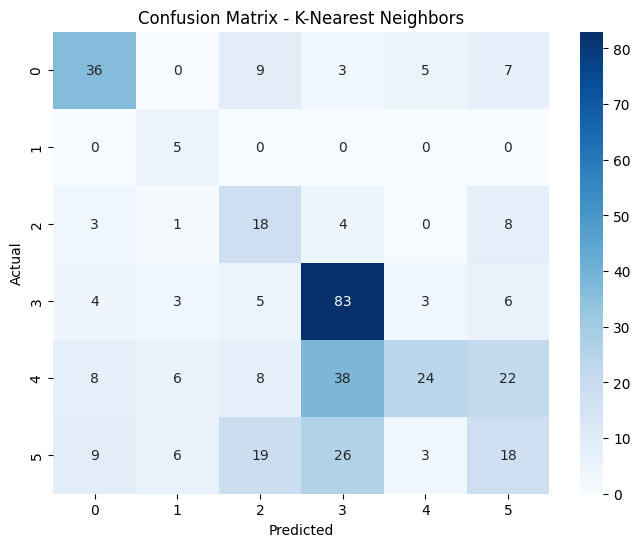

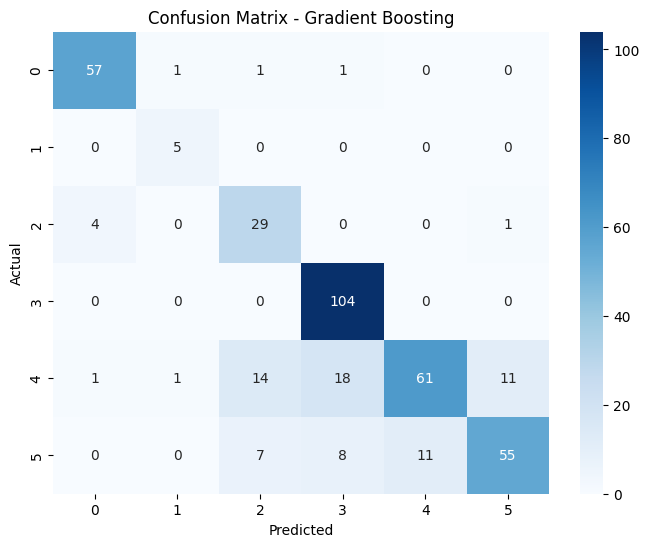

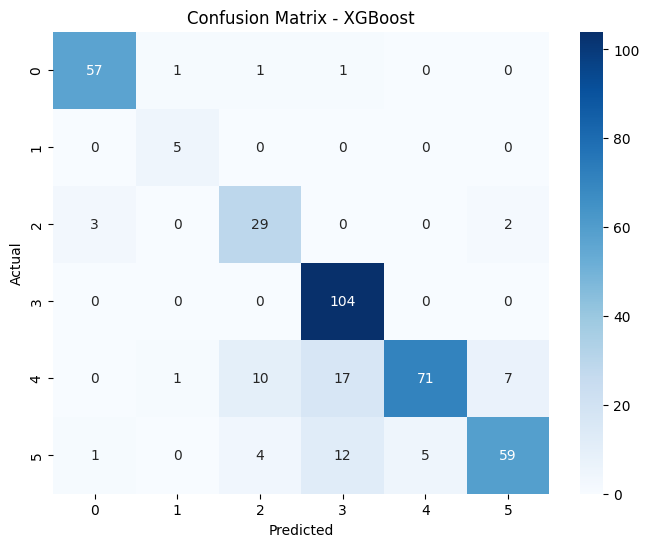

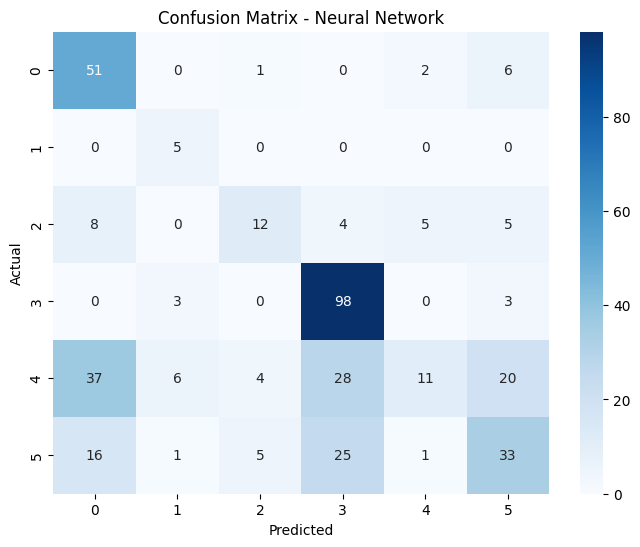

In [9]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    # 'LightGBM': lgb.LGBMClassifier(max_depth=6, random_state=42,min_data_in_leaf=20),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}


# Обучение моделей и сбор результатов
results = []

for name, model in models.items():
    print(f"Обучение модели: {name}")
    model.fit(X_train, y_train)  # Обучение модели на обучающей выборке
    
    # Предсказания для тестовых данных
    y_pred = model.predict(X_test)
    
    # Генерация отчёта
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Извлечение метрик
    accuracy = report['accuracy']
    precision = np.mean([
        v['precision'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    recall = np.mean([
        v['recall'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    f1 = np.mean([
        v['f1-score'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    
    # Сохранение результатов
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)
print("\nРезультаты моделей:")
print(results_df)


# Визуализация с помощью barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='F1-Score', y='Model', data=results_df.sort_values('F1-Score', ascending=False))
plt.title('Сравнение моделей по F1-Score')
plt.xlabel('F1-Score')
plt.ylabel('Модель')
plt.xlim(0, 1)
plt.show()

# Дополнительно: Матрицы путаницы для каждой модели
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [10]:

# Обучение лучшей модели
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Предсказания для тестовых данных
y_pred = best_model.predict(X_test)

# Вывод полного отчёта
report = classification_report(
    y_test,
    y_pred,
    labels=range(len(all_classes)),  # Указание всех возможных классов
    target_names=all_classes
)
print("Классификационный отчёт для лучшей модели:")
print(report)


Классификационный отчёт для лучшей модели:
               precision    recall  f1-score   support

   leg raises       0.93      0.93      0.93        60
        plank       0.62      1.00      0.77         5
      pull Up       0.77      0.88      0.82        34
      push-up       0.74      1.00      0.85       104
russian twist       1.00      0.54      0.70       106
        squat       0.79      0.84      0.81        81

     accuracy                           0.82       390
    macro avg       0.81      0.87      0.82       390
 weighted avg       0.85      0.82      0.81       390



In [11]:
best_model =xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
best_model.fit(X_train, y_train)

# Предсказания для тестовых данных
y_pred = best_model.predict(X_test)

# Вывод полного отчёта
report = classification_report(
    y_test,
    y_pred,
    labels=range(len(all_classes)),  # Указание всех возможных классов
    target_names=all_classes
)
print("Классификационный отчёт для лучшей модели:")
print(report)


Классификационный отчёт для лучшей модели:
               precision    recall  f1-score   support

   leg raises       0.93      0.95      0.94        60
        plank       0.71      1.00      0.83         5
      pull Up       0.66      0.85      0.74        34
      push-up       0.78      1.00      0.87       104
russian twist       0.93      0.67      0.78       106
        squat       0.87      0.73      0.79        81

     accuracy                           0.83       390
    macro avg       0.81      0.87      0.83       390
 weighted avg       0.85      0.83      0.83       390

